In [88]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import keras
from keras.preprocessing import image
from keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import *
import visualkeras
from numpy.random import *
from numpy import *

In [89]:
img_size = (32,32)

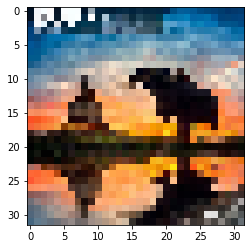

In [90]:
def list_file_in_path(img_size=img_size):
    img_path = './Art_Bangkok/WaterColor'
    import os
    file_list = []
    for root, dirs, files in os.walk(img_path):
        for file in files:
            tmp_file = cv2.imread(os.path.join(root, file))
            tmp_file = cv2.resize(tmp_file , img_size, interpolation=cv2.INTER_LINEAR)
            tmp_file = cv2.cvtColor(tmp_file, cv2.COLOR_BGR2RGB)
            file_list.append(tmp_file)
    return file_list

all_image = list_file_in_path()
train_dataset = list_file_in_path()
train_dataset = np.array(train_dataset) / 255.0
def generate_real_samples(dataset, n_samples):
    dataset = np.array(dataset)
    ix = randint(0,  dataset.shape[0], n_samples)
    X = dataset[ix]
    y = np.ones((n_samples, 1))
    return X, y

x_real, y_real = generate_real_samples(train_dataset, 100)
plt.imshow(x_real[0])

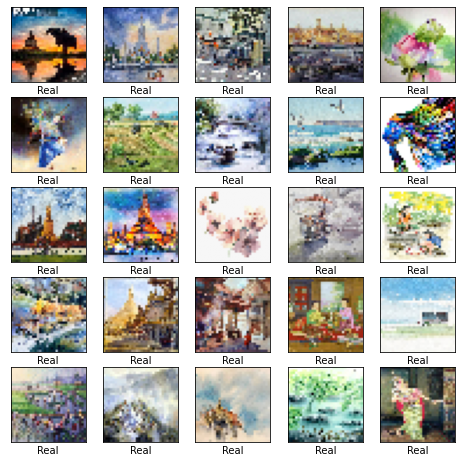

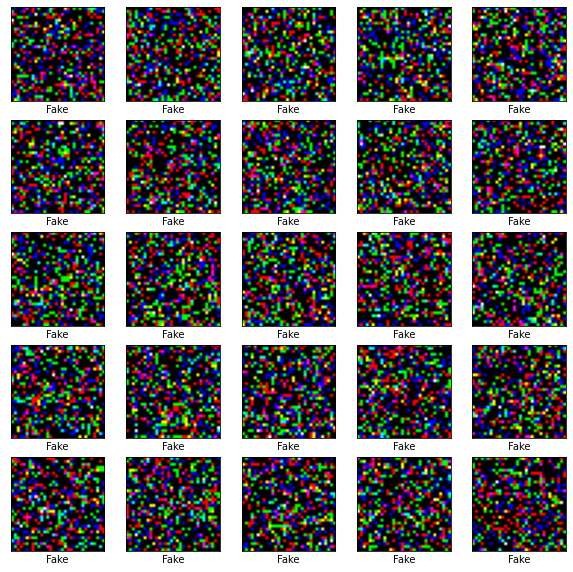

In [91]:
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = zeros((n_samples, 1))
    return X, y

def test_generate_fake_samples(n_samples,target_size=img_size):
    hwc = (target_size[0],target_size[1],3)
    X = randn(n_samples, *hwc).astype(np.uint8)
    y = zeros((n_samples, 1))
    return X, y

x_fake, y_fake = test_generate_fake_samples(100)
# View Training Images and Validation Images

def show_all_image():
    plt.figure(figsize=(8,8))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(x_real[i], cmap=plt.cm.binary)
        plt.xlabel('Real')
    plt.show()
    plt.figure(figsize=(10,10))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(x_fake[i], cmap=plt.cm.binary)
        plt.xlabel('Fake')
    plt.show()

show_all_image()

In [92]:
def define_discriminator(input_shape = (img_size[0],img_size[1],3)):
      # DEFINE MODEL
    model = Sequential()
    #normal
    model.add(Conv2D(64,(3,3),strides=(2,2),padding='same',input_shape= input_shape))
    model.add(Activation(LeakyReLU(0.2)))
    #down
    model.add(Conv2D(128,(3,3),strides=(2,2),padding='same'))
    model.add(Activation(LeakyReLU(0.2)))
    #down
    model.add(Conv2D(128,(3,3),strides=(2,2),padding='same'))
    model.add(Activation(LeakyReLU(0.2)))
    #down
    model.add(Conv2D(256,(3,3),strides=(2,2),padding='same'))
    model.add(Activation(LeakyReLU(0.2)))
    #classifier
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1,activation='sigmoid'))
    opt = Adam(lr=0.0002, beta_1=0.5)
    # COMPILE MODEL
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [93]:
def train_discriminator(model,x_real,x_fake,y_real,y_fake,epochs=100,batch_size=128):
    # TRAIN MODEL
    d_loss = []
    d_acc = []
    for epoch in range(epochs):
        # TRAIN DISCRIMINATOR
        # REAL DATA
        idx = np.random.randint(0, x_real.shape[0], batch_size)
        real_images = x_real[idx]
        real_labels = y_real[idx]
        d_loss_real, d_acc_real = model.train_on_batch(real_images, real_labels)
        # FAKE DATA
        idx = np.random.randint(0, x_fake.shape[0], batch_size)
        fake_images = x_fake[idx]
        fake_labels = y_fake[idx]
        d_loss_fake, d_acc_fake = model.train_on_batch(fake_images, fake_labels)
        # AVERAGE LOSS AND ACCURACY
        d_loss.append((d_loss_real + d_loss_fake) / 2)
        d_acc.append((d_acc_real + d_acc_fake) / 2)
        print('>%d, d_loss=%.3f, d_acc=%.3f' % (epoch + 1, d_loss[-1], d_acc[-1]))
    return d_loss, d_acc

In [95]:
d_model = define_discriminator()
d_model.summary()
train_discriminator(d_model,x_real,x_fake,y_real,y_fake,batch_size=128)

Model: "sequential_76"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_177 (Conv2D)         (None, 16, 16, 64)        1792      
                                                                 
 activation_159 (Activation)  (None, 16, 16, 64)       0         
                                                                 
 conv2d_178 (Conv2D)         (None, 8, 8, 128)         73856     
                                                                 
 activation_160 (Activation)  (None, 8, 8, 128)        0         
                                                                 
 conv2d_179 (Conv2D)         (None, 4, 4, 128)         147584    
                                                                 
 activation_161 (Activation)  (None, 4, 4, 128)        0         
                                                                 
 conv2d_180 (Conv2D)         (None, 2, 2, 256)       

([2.363597095012665,
  0.34886413533240557,
  0.360039665239583,
  0.361736516093373,
  0.3596883058835374,
  0.35762698894319556,
  0.35569221757259584,
  0.35279750280824373,
  0.35132335220987443,
  0.3472500544748982,
  0.34425498681684985,
  0.3422455421800805,
  0.3386793194690654,
  0.33661867621844976,
  0.3323444916572953,
  0.3307648476211398,
  0.3268918012017821,
  0.32476447787757934,
  0.3207233839730179,
  0.32084139389917254,
  0.31559175316942856,
  0.31153278578312893,
  0.3076316457727444,
  0.3042981017661077,
  0.2984491849929327,
  0.29470908612711355,
  0.28954570420319214,
  0.2860312722623348,
  0.2791696733329445,
  0.27152141073020175,
  0.2757502533495426,
  0.2606456567409623,
  0.2576214992441237,
  0.24701684622414177,
  0.24717981508001685,
  0.2325600298063364,
  0.2263121385622071,
  0.2129228138801409,
  0.22097793966531754,
  0.20705295208902763,
  0.20051084480608738,
  0.19404681039256572,
  0.182815984570058,
  0.16814982918693033,
  0.15578988190

In [96]:
def define_generator(latent_dim,disc_output_shape=(256,4,4)):
    model = Sequential()
    # foundation for 4x4 image
    c,w,h = disc_output_shape
    n_nodes = c*w*h
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((w, h, c)))
    # upsample
    model.add(Conv2DTranspose(128, (w, h), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample
    model.add(Conv2DTranspose(128, (w, h), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample
    model.add(Conv2DTranspose(128, (w, h), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
    return model

g_model = define_generator(latent_dim=100)
g_model.summary()

Model: "sequential_77"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_57 (Dense)            (None, 4096)              413696    
                                                                 
 leaky_re_lu_223 (LeakyReLU)  (None, 4096)             0         
                                                                 
 reshape_15 (Reshape)        (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose_45 (Conv2D  (None, 8, 8, 128)        524416    
 Transpose)                                                      
                                                                 
 leaky_re_lu_224 (LeakyReLU)  (None, 8, 8, 128)        0         
                                                                 
 conv2d_transpose_46 (Conv2D  (None, 16, 16, 128)      262272    
 Transpose)                                          

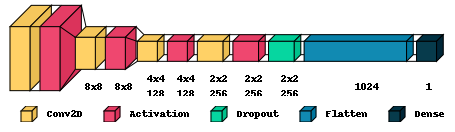

In [97]:
visualkeras.layered_view(d_model,draw_shapes=1,legend=True)

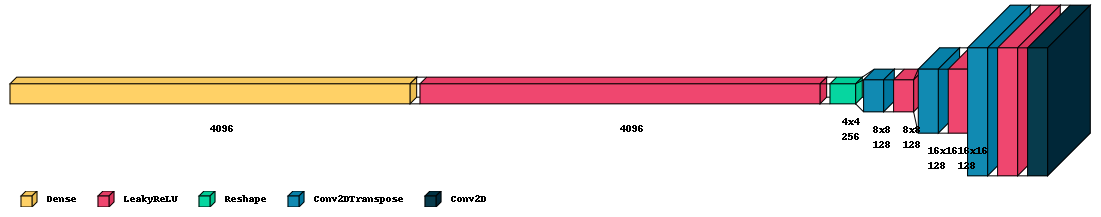

In [98]:
visualkeras.layered_view(g_model,draw_shapes=1,legend=True)

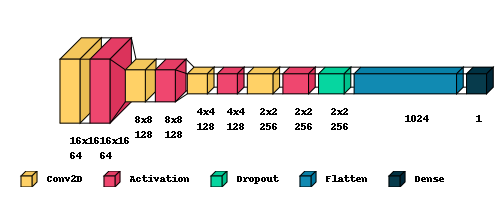

In [104]:
visualkeras.layered_view(d_model,draw_shapes=1,legend=True,padding_left=50,padding_vertical=75)

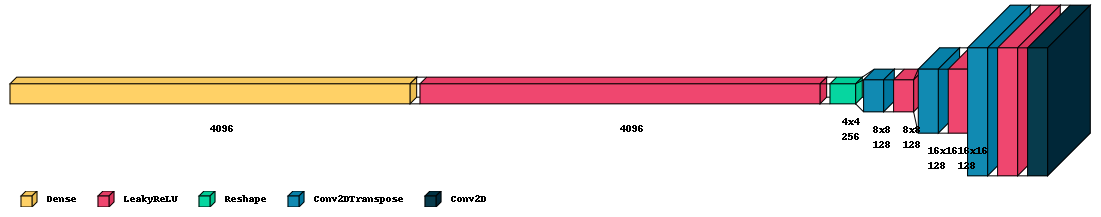

In [105]:
visualkeras.layered_view(g_model,draw_shapes=1,legend=True)

In [108]:
def define_gan(g_model, d_model, image_shape=(img_size[0],img_size[1],3)):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model
# generate points in latent space as input for the generator

def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

def train(g_model, d_model, gan_model, dataset, latent_dim,n_batch=128,n_epochs=50):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    d_loss1 = 0
    d_loss2 = 0
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
        # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = np.ones((n_batch, 1))
            # update the generator via the discriminator✬s error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
        # summarize loss on this epoch
        print('>%d, discriminator_Loss=%.3f, generator_Loss=%.3f' % (i+1, d_loss1, d_loss2))
        # evaluate the model performance, sometimes
        if (i+1) % 1000 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)
# evaluate the discriminator, plot generated images, save generator model

def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    # prepare real samples
    X_real, y_real = generate_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    print(X_real.shape, y_real.shape)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    # save the generator model tile file
    filename = './Saved_model/generator_model_%03d.h5' % (epoch + 1)
    g_model.save(filename)

gan_model = define_gan(g_model, d_model)
gan_model.summary()

Model: "sequential_79"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_77 (Sequential)  (None, 32, 32, 3)         1466115   
                                                                 
 sequential_76 (Sequential)  (None, 1)                 519425    
                                                                 
Total params: 1,985,540
Trainable params: 1,466,115
Non-trainable params: 519,425
_________________________________________________________________


In [109]:
train(g_model, d_model, gan_model, train_dataset, latent_dim=100,n_epochs=3000)

>1, discriminator_Loss=0.653, generator_Loss=0.736
>2, discriminator_Loss=0.649, generator_Loss=0.733
>3, discriminator_Loss=0.653, generator_Loss=0.737
>4, discriminator_Loss=0.651, generator_Loss=0.736
>5, discriminator_Loss=0.660, generator_Loss=0.738
>6, discriminator_Loss=0.668, generator_Loss=0.738
>7, discriminator_Loss=0.673, generator_Loss=0.732
>8, discriminator_Loss=0.679, generator_Loss=0.730
>9, discriminator_Loss=0.676, generator_Loss=0.709
>10, discriminator_Loss=0.670, generator_Loss=0.704
>11, discriminator_Loss=0.668, generator_Loss=0.707
>12, discriminator_Loss=0.670, generator_Loss=0.718
>13, discriminator_Loss=0.674, generator_Loss=0.729
>14, discriminator_Loss=0.690, generator_Loss=0.703
>15, discriminator_Loss=0.706, generator_Loss=0.685
>16, discriminator_Loss=0.712, generator_Loss=0.683
>17, discriminator_Loss=0.719, generator_Loss=0.675
>18, discriminator_Loss=0.718, generator_Loss=0.675
>19, discriminator_Loss=0.712, generator_Loss=0.681
>20, discriminator_Lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

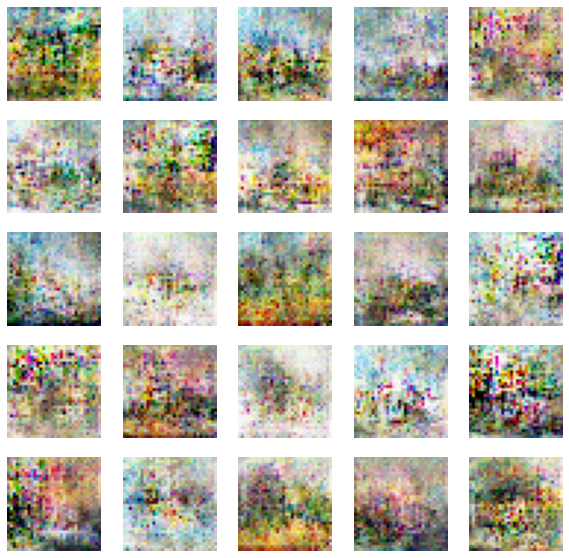

In [110]:
X = g_model.predict(generate_latent_points(100,1))
# plot the result

def plot_all_image():
    plt.figure(figsize=(10,10))
    for i in range(25):
        X = g_model.predict(generate_latent_points(100,1))
        plt.subplot(5,5,i+1)
        plt.imshow(X[0,:,:,:])
        plt.axis('off')
    plt.show()

plot_all_image()